**Install Dependencies**

In [1]:
#%pip install missingno

**Imports**

In [5]:
import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

**Load Data:**

In [7]:
filename = './../../data/intents_generated.json'

with open(filename) as f:
    intents = json.load(f)

intents

{'intents': [{'tag': 'greeting',
   'patterns': ['Hi',
    'How are you?',
    'Is anyone there?',
    'Hello',
    'Good day',
    "What's up",
    'how are ya',
    'heyy',
    'whatsup',
    '??? ??? ??'],
   'responses': ['Hello!',
    'Good to see you again!',
    'Hi there, how can I help?'],
   'context_set': ''},
  {'tag': 'goodbye',
   'patterns': ['cya',
    'see you',
    'bye bye',
    'See you later',
    'Goodbye',
    'I am Leaving',
    'Bye',
    'Have a Good day',
    'talk to you later',
    'ttyl',
    'i got to go',
    'gtg'],
   'responses': ['Sad to see you go :(',
    'Talk to you later',
    'Goodbye!',
    'Come back soon'],
   'context_set': ''},
  {'tag': 'creator',
   'patterns': ['what is the name of your developers',
    'what is the name of your creators',
    'what is the name of the developers',
    'what is the name of the creators',
    'who created you',
    'your developers',
    'your creators',
    'who are your developers',
    'developers',
  

In [9]:
def create_and_extract_info(json_file):
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    for intent in json_file['intents']:
        for pattern in intent['patterns']:
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = create_and_extract_info(intents)
df2 = df.copy()
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


**About the data**:

In [11]:
df.shape

(480, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  480 non-null    object
 1   Tag      480 non-null    object
dtypes: object(2)
memory usage: 11.2+ KB


**Number of classes**:

In [13]:
len(df['Tag'].unique())

53

In [14]:
df.isnull().sum()

Pattern    0
Tag        0
dtype: int64

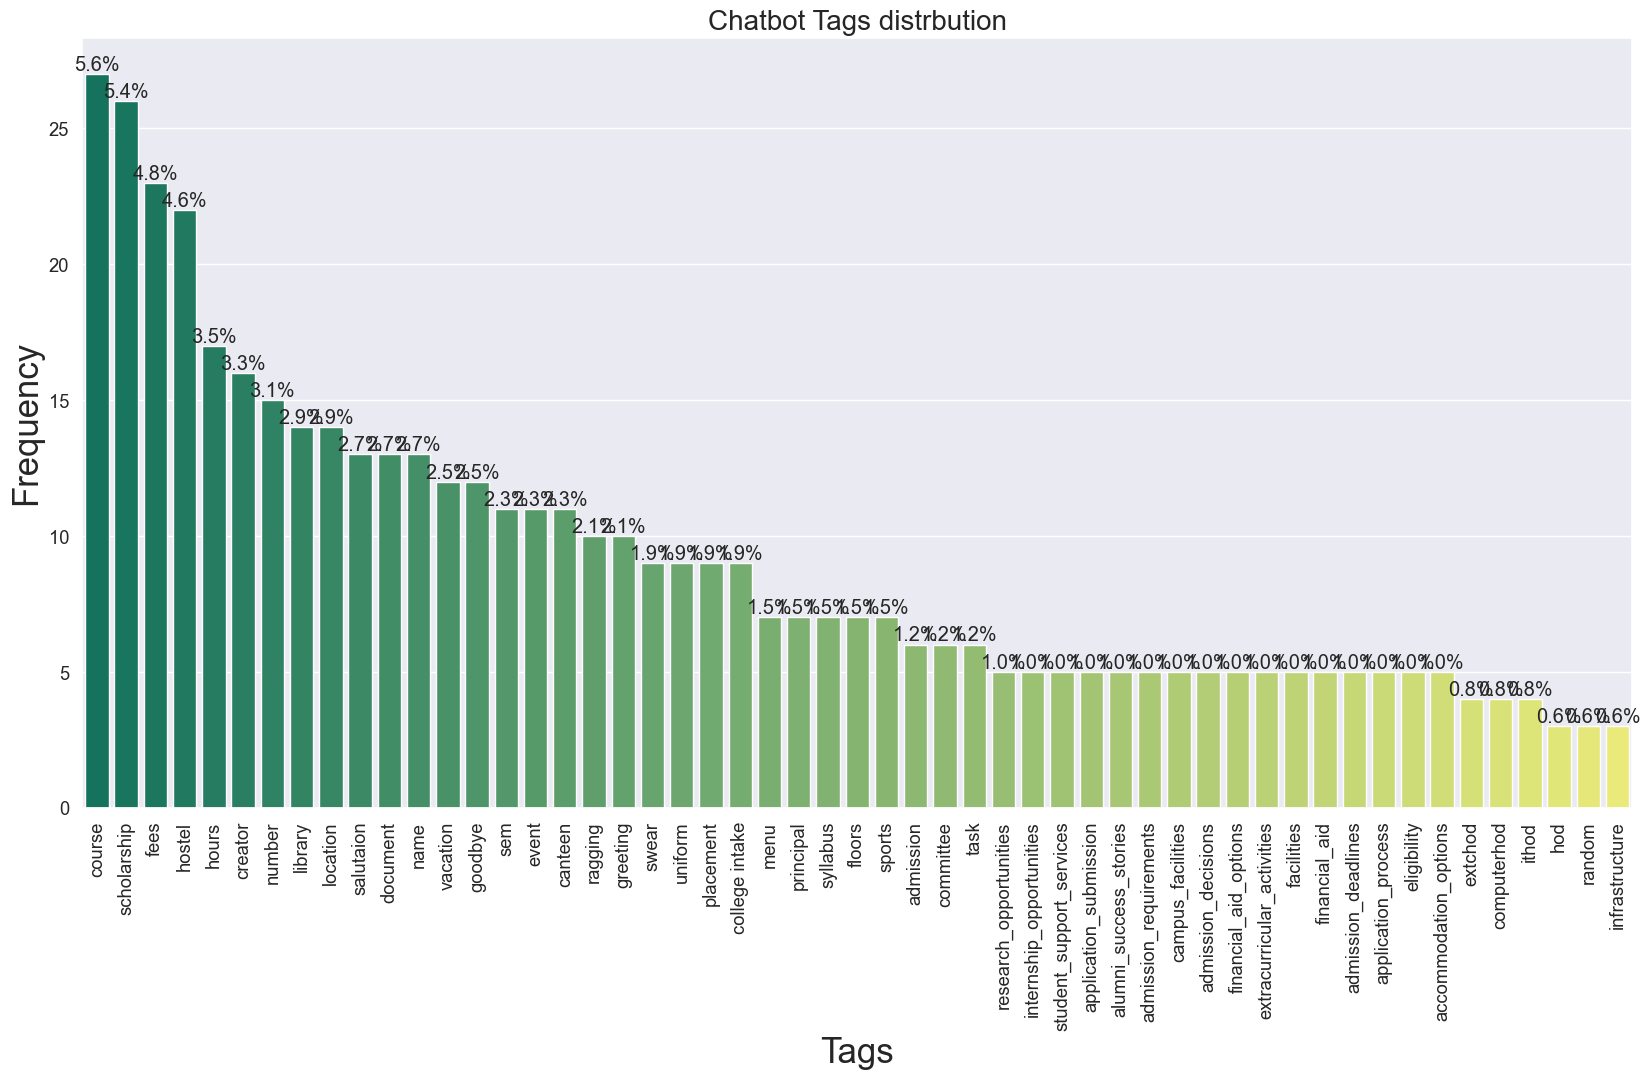

In [16]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [17]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


**Pre-processing**:

In [18]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod',
 'eligibility',
 'application_process',
 'admission_deadlines',
 'financial_aid',
 'campus_facilities',
 'extracurricular_activities',
 'student_support_services',
 'internship_opportunities',
 'research_opportunities',
 'alumni_success_stories',
 'admission_requirements',
 'application_submission',
 'admission_decisions',
 'financial_aid_options',
 'accommodation_options']

In [19]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod',
 38: 'eligibility',
 39: 'application_process',
 40: 'admission_deadlines',
 41: 'financial_aid',
 42: 'campus_facilities',
 43: 'extracurricular_activities',
 44: 'student_support_services',
 45: 'internship_opportunities',
 46: 'research_opportunities',
 47: 'alumni_success_stories',
 48: 'admission_requirements',
 49: 'application_submission',
 50: 'admission_decisions',
 51: 'financial_aid

In [20]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37,
 'eligibility': 38,
 'application_process': 39,
 'admission_deadlines': 40,
 'financial_aid': 41,
 'campus_facilities': 42,
 'extracurricular_activities': 43,
 'student_support_services': 44,
 'internship_opportunities': 45,
 'research_opportunities': 46,
 'alumni_success_stories': 47,
 'admission_requirements': 48,
 'application_submission': 49,
 'admission_decisions': 50,
 'financial_aid_opt

In [21]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


In [22]:
X = list(df2['Pattern'])
X[:5]

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']

In [23]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

**Preparing benchmark data**

In [31]:
json_data = json.load(open('../../data/benchmarkData.json'))

label2id = {key: i for i, key in enumerate(json_data.keys())}

X_test = []
Y_test = []

for key, values in json_data.items():
    for value in values:
        X_test.append(value)
        Y_test.append(label2id[key])

print(X_test)
print(Y_test)

['Hello!', 'Hey there!', "Hi, how's it going?", 'Goodbye!', 'See you later!', 'Farewell!', 'Who created you?', 'Tell me about your creator.', 'Who made this bot?', "What's your university's name?", 'Tell me the name of your college.', 'University name?', 'What are your working hours?', 'When are you open?', 'Office hours?', 'Can I get the contact number?', 'Give me the phone number.', 'Contact details?', 'Tell me about engineering courses.', 'Information on computer science program?', 'Engineering details.', 'How much are the fees?', 'Tell me about the costs.', 'Fees for engineering program?', 'Where is your university located?', 'Give me the location.', 'University address?', 'Tell me about hostel facilities.', 'Information on accommodation?', 'Hostel details.', 'Are there any upcoming events?', 'Tell me about university events.', 'Any events for new students?', 'Which documents are required?', 'Documents for admission?', 'Required paperwork?', 'How many floors does the building have?

**Load BERT**

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)

model = BertForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
)

In [32]:
train_encoding = tokenizer(X, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [33]:
full_data = tokenizer(X, truncation=True, padding=True)

**Data loader**

In [34]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [36]:
train_dataloader = DataLoader(train_encoding, y)
test_dataloader = DataLoader(test_encoding, Y_test)


In [38]:
fullDataLoader = DataLoader(full_data, y)

**Defining benchmarks**:

In [39]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

**Training**

In [40]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [42]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)
trainer.train()

  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss': 3.7628, 'learning_rate': 2.5e-05, 'epoch': 3.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 3.881092071533203, 'eval_Accuracy': 0.08928571428571429, 'eval_F1': 0.05318019930208296, 'eval_Precision': 0.06505862558494137, 'eval_Recall': 0.08771929824561403, 'eval_runtime': 2.2985, 'eval_samples_per_second': 48.728, 'eval_steps_per_second': 3.045, 'epoch': 3.33}
{'loss': 3.1132, 'learning_rate': 5e-05, 'epoch': 6.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 3.3517706394195557, 'eval_Accuracy': 0.25, 'eval_F1': 0.19675583188741083, 'eval_Precision': 0.23511181012364632, 'eval_Recall': 0.2456140350877193, 'eval_runtime': 2.3533, 'eval_samples_per_second': 47.593, 'eval_steps_per_second': 2.975, 'epoch': 6.67}
{'loss': 1.8044, 'learning_rate': 4.8214285714285716e-05, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 2.0754826068878174, 'eval_Accuracy': 0.6428571428571429, 'eval_F1': 0.5181985972683647, 'eval_Precision': 0.52984496124031, 'eval_Recall': 0.5581395348837209, 'eval_runtime': 2.3754, 'eval_samples_per_second': 47.149, 'eval_steps_per_second': 2.947, 'epoch': 10.0}
{'loss': 0.8281, 'learning_rate': 4.642857142857143e-05, 'epoch': 13.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.5972334146499634, 'eval_Accuracy': 0.6875, 'eval_F1': 0.5617473435655254, 'eval_Precision': 0.5943993506493507, 'eval_Recall': 0.5833333333333333, 'eval_runtime': 4.0107, 'eval_samples_per_second': 27.926, 'eval_steps_per_second': 1.745, 'epoch': 13.33}
{'loss': 0.3711, 'learning_rate': 4.464285714285715e-05, 'epoch': 16.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.4841912984848022, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.5781230674087817, 'eval_Precision': 0.5925453514739228, 'eval_Recall': 0.6190476190476191, 'eval_runtime': 4.7417, 'eval_samples_per_second': 23.62, 'eval_steps_per_second': 1.476, 'epoch': 16.67}
{'loss': 0.1725, 'learning_rate': 4.2857142857142856e-05, 'epoch': 20.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.5402761697769165, 'eval_Accuracy': 0.6785714285714286, 'eval_F1': 0.5481601731601732, 'eval_Precision': 0.5699675324675325, 'eval_Recall': 0.5757575757575757, 'eval_runtime': 2.751, 'eval_samples_per_second': 40.712, 'eval_steps_per_second': 2.544, 'epoch': 20.0}
{'loss': 0.0875, 'learning_rate': 4.107142857142857e-05, 'epoch': 23.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.5519462823867798, 'eval_Accuracy': 0.6696428571428571, 'eval_F1': 0.5240730284208546, 'eval_Precision': 0.5515269151138716, 'eval_Recall': 0.5434782608695652, 'eval_runtime': 3.5994, 'eval_samples_per_second': 31.116, 'eval_steps_per_second': 1.945, 'epoch': 23.33}
{'loss': 0.0557, 'learning_rate': 3.928571428571429e-05, 'epoch': 26.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.5303804874420166, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5728945297127116, 'eval_Precision': 0.5993235930735931, 'eval_Recall': 0.5984848484848485, 'eval_runtime': 3.9726, 'eval_samples_per_second': 28.193, 'eval_steps_per_second': 1.762, 'epoch': 26.67}
{'loss': 0.0403, 'learning_rate': 3.7500000000000003e-05, 'epoch': 30.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.5732542276382446, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.5583116883116883, 'eval_Precision': 0.5935185185185186, 'eval_Recall': 0.5777777777777777, 'eval_runtime': 2.6384, 'eval_samples_per_second': 42.45, 'eval_steps_per_second': 2.653, 'epoch': 30.0}
{'loss': 0.0295, 'learning_rate': 3.571428571428572e-05, 'epoch': 33.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.610016942024231, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5735487996851633, 'eval_Precision': 0.6003787878787878, 'eval_Recall': 0.5984848484848485, 'eval_runtime': 4.0338, 'eval_samples_per_second': 27.766, 'eval_steps_per_second': 1.735, 'epoch': 33.33}
{'loss': 0.0261, 'learning_rate': 3.392857142857143e-05, 'epoch': 36.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.660509705543518, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.568349075167257, 'eval_Precision': 0.5993235930735931, 'eval_Recall': 0.5909090909090909, 'eval_runtime': 2.6036, 'eval_samples_per_second': 43.017, 'eval_steps_per_second': 2.689, 'epoch': 36.67}
{'loss': 0.0212, 'learning_rate': 3.2142857142857144e-05, 'epoch': 40.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.6549888849258423, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.5681326249508067, 'eval_Precision': 0.6012175324675325, 'eval_Recall': 0.5909090909090909, 'eval_runtime': 2.5082, 'eval_samples_per_second': 44.654, 'eval_steps_per_second': 2.791, 'epoch': 40.0}
{'loss': 0.0196, 'learning_rate': 3.0357142857142857e-05, 'epoch': 43.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.6474778652191162, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.5634248327430146, 'eval_Precision': 0.5788690476190476, 'eval_Recall': 0.5909090909090909, 'eval_runtime': 2.4879, 'eval_samples_per_second': 45.019, 'eval_steps_per_second': 2.814, 'epoch': 43.33}
{'loss': 0.0179, 'learning_rate': 2.857142857142857e-05, 'epoch': 46.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.68394935131073, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5726780794962614, 'eval_Precision': 0.6012175324675325, 'eval_Recall': 0.5984848484848485, 'eval_runtime': 2.4115, 'eval_samples_per_second': 46.444, 'eval_steps_per_second': 2.903, 'epoch': 46.67}
{'loss': 0.0153, 'learning_rate': 2.6785714285714288e-05, 'epoch': 50.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7109616994857788, 'eval_Accuracy': 0.6964285714285714, 'eval_F1': 0.5488407888407889, 'eval_Precision': 0.5656349206349206, 'eval_Recall': 0.5777777777777777, 'eval_runtime': 2.4036, 'eval_samples_per_second': 46.597, 'eval_steps_per_second': 2.912, 'epoch': 50.0}
{'loss': 0.0147, 'learning_rate': 2.5e-05, 'epoch': 53.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7131423950195312, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5561471861471862, 'eval_Precision': 0.5666666666666667, 'eval_Recall': 0.5851851851851853, 'eval_runtime': 2.4053, 'eval_samples_per_second': 46.563, 'eval_steps_per_second': 2.91, 'epoch': 53.33}
{'loss': 0.0132, 'learning_rate': 2.3214285714285715e-05, 'epoch': 56.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7541561126708984, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5555074555074555, 'eval_Precision': 0.5656349206349206, 'eval_Recall': 0.5851851851851853, 'eval_runtime': 2.4304, 'eval_samples_per_second': 46.083, 'eval_steps_per_second': 2.88, 'epoch': 56.67}
{'loss': 0.0135, 'learning_rate': 2.1428571428571428e-05, 'epoch': 60.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7654396295547485, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5573593073593074, 'eval_Precision': 0.567857142857143, 'eval_Recall': 0.5851851851851853, 'eval_runtime': 2.561, 'eval_samples_per_second': 43.733, 'eval_steps_per_second': 2.733, 'epoch': 60.0}
{'loss': 0.0127, 'learning_rate': 1.9642857142857145e-05, 'epoch': 63.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7745935916900635, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5684704184704185, 'eval_Precision': 0.5900793650793651, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.5497, 'eval_samples_per_second': 43.927, 'eval_steps_per_second': 2.745, 'epoch': 63.33}
{'loss': 0.0113, 'learning_rate': 1.785714285714286e-05, 'epoch': 66.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7547807693481445, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.5237, 'eval_samples_per_second': 44.38, 'eval_steps_per_second': 2.774, 'epoch': 66.67}
{'loss': 0.0119, 'learning_rate': 1.6071428571428572e-05, 'epoch': 70.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7749165296554565, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 4.4699, 'eval_samples_per_second': 25.057, 'eval_steps_per_second': 1.566, 'epoch': 70.0}
{'loss': 0.011, 'learning_rate': 1.4285714285714285e-05, 'epoch': 73.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7688649892807007, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 4.2131, 'eval_samples_per_second': 26.584, 'eval_steps_per_second': 1.661, 'epoch': 73.33}
{'loss': 0.0098, 'learning_rate': 1.25e-05, 'epoch': 76.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7831999063491821, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.3308, 'eval_samples_per_second': 48.051, 'eval_steps_per_second': 3.003, 'epoch': 76.67}
{'loss': 0.011, 'learning_rate': 1.0714285714285714e-05, 'epoch': 80.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7884587049484253, 'eval_Accuracy': 0.7053571428571429, 'eval_F1': 0.5561471861471862, 'eval_Precision': 0.5666666666666667, 'eval_Recall': 0.5851851851851853, 'eval_runtime': 2.708, 'eval_samples_per_second': 41.36, 'eval_steps_per_second': 2.585, 'epoch': 80.0}
{'loss': 0.0097, 'learning_rate': 8.92857142857143e-06, 'epoch': 83.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7741962671279907, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.7294, 'eval_samples_per_second': 41.034, 'eval_steps_per_second': 2.565, 'epoch': 83.33}
{'loss': 0.0098, 'learning_rate': 7.142857142857143e-06, 'epoch': 86.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7765884399414062, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5666185666185666, 'eval_Precision': 0.5878571428571429, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.6272, 'eval_samples_per_second': 42.632, 'eval_steps_per_second': 2.664, 'epoch': 86.67}
{'loss': 0.0097, 'learning_rate': 5.357142857142857e-06, 'epoch': 90.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7788952589035034, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5672582972582972, 'eval_Precision': 0.5888888888888889, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.6699, 'eval_samples_per_second': 41.949, 'eval_steps_per_second': 2.622, 'epoch': 90.0}
{'loss': 0.0094, 'learning_rate': 3.5714285714285714e-06, 'epoch': 93.33}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7851511240005493, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5666185666185666, 'eval_Precision': 0.5878571428571429, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 5.0187, 'eval_samples_per_second': 22.316, 'eval_steps_per_second': 1.395, 'epoch': 93.33}
{'loss': 0.009, 'learning_rate': 1.7857142857142857e-06, 'epoch': 96.67}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7922941446304321, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5666185666185666, 'eval_Precision': 0.5878571428571429, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.4954, 'eval_samples_per_second': 44.882, 'eval_steps_per_second': 2.805, 'epoch': 96.67}
{'loss': 0.0095, 'learning_rate': 0.0, 'epoch': 100.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 1.7940393686294556, 'eval_Accuracy': 0.7142857142857143, 'eval_F1': 0.5666185666185666, 'eval_Precision': 0.5878571428571429, 'eval_Recall': 0.5925925925925927, 'eval_runtime': 2.5569, 'eval_samples_per_second': 43.802, 'eval_steps_per_second': 2.738, 'epoch': 100.0}
{'train_runtime': 5907.6097, 'train_samples_per_second': 8.125, 'train_steps_per_second': 0.254, 'train_loss': 0.3510466123620669, 'epoch': 100.0}


TrainOutput(global_step=1500, training_loss=0.3510466123620669, metrics={'train_runtime': 5907.6097, 'train_samples_per_second': 8.125, 'train_steps_per_second': 0.254, 'train_loss': 0.3510466123620669, 'epoch': 100.0})

**Benchmarks**

In [43]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.019423,0.997917,0.999160,0.999214,0.999142
test,1.610017,0.705357,0.573549,0.600379,0.598485


**Testing**:

In [46]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [47]:
text = "Hello"
predict(text)

(tensor([[9.8368e-01, 5.1718e-04, 1.9854e-04, 1.0556e-03, 1.1273e-03, 4.8115e-04,
          3.5865e-04, 1.7812e-04, 1.8270e-04, 6.2488e-05, 6.8618e-04, 1.1292e-04,
          4.6455e-04, 2.5601e-04, 3.5142e-04, 4.3897e-05, 1.1325e-04, 3.0353e-04,
          1.9892e-04, 1.2220e-04, 4.3065e-04, 5.7678e-05, 3.6618e-04, 7.9158e-05,
          2.4947e-05, 1.5731e-04, 6.8521e-05, 5.4451e-05, 2.6307e-04, 1.5276e-04,
          2.7185e-04, 2.7927e-04, 7.9553e-04, 1.7189e-04, 1.4135e-03, 1.5893e-04,
          5.4597e-04, 1.0143e-04, 1.5498e-04, 4.6485e-04, 3.4106e-04, 4.1937e-05,
          1.3371e-04, 9.6837e-05, 9.2120e-05, 5.0723e-05, 3.9958e-04, 1.1959e-04,
          1.3861e-04, 5.2403e-04, 3.1688e-04, 4.4479e-04, 7.9203e-04]],
        grad_fn=<SoftmaxBackward0>),
 tensor(0),
 'greeting')

**Compile**:

In [49]:
model_path = "./bin"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('./bin\\tokenizer_config.json',
 './bin\\special_tokens_map.json',
 './bin\\vocab.txt',
 './bin\\added_tokens.json')

**A test drive**

In [50]:
model_path = "./bin"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [51]:
def chat(chatbot, text):
    text = text.strip().lower()
    score = chatbot(text)[0]['score']

    if score < 0.8:
        return "Sorry I can't answer that"

    label = label2id[chatbot(text)[0]['label']]
    response = random.choice(intents['intents'][label]['responses'])

    return response

In [53]:
chat(chatbot, 'hello')

'Hi there, how can I help?'